# Imports

In [1]:
!nvidia-smi

Sat Dec  3 01:03:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers --quiet
!pip install sentencepiece --quiet

     |████████████████████████████████| 5.8 MB 25.4 MB/s 
     |████████████████████████████████| 182 kB 70.4 MB/s 
     |████████████████████████████████| 7.6 MB 72.7 MB/s 
     |████████████████████████████████| 1.3 MB 11.4 MB/s 


In [3]:
import os
import sys
import time
import string
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, \
  LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from transformers import BertTokenizer, TFBertModel, AutoModel, AutoTokenizer
from transformers import BertConfig, BertTokenizer, TFBertModel
import transformers

## Global Variables and Google Drive Connect

In [4]:
TESTING = False # use to truncate training data in order to speed up development

RANDOM_STATE = 42
SEQUENCE_LENGTH = 512
BATCH_SIZE = 1
USER = 'Alex'
RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']
PATIENCE = 2
LEARNING_RATE = 0.0001
LEARNING_RATE_DECAY = 0.1
EPOCHS = 4
# Uncomment these two lines if you want to be able to be able to repeat calculations exactly on the same hardware
# However, the model will run more slowly (approx 1/3 speed)
# tf.keras.utils.set_random_seed(RANDOM_STATE)
# tf.config.experimental.enable_op_determinism()

In [5]:
# Mount drive where you will do your work.
drive.mount('/content/drive')
if USER == 'Alex': 
  root_dir = "/content/drive/MyDrive/w266/"
  project_folder = "Final_Project/"
elif USER == 'Kurt':
  root_dir = "/content/drive/My Drive/266/"
  project_folder = "Final Project/"
elif USER == 'Tom':
  root_dir = "/content/drive/My Drive/UC Berkeley/W266 Natural Language Processing/"
  project_folder = "Final Project/"
else:
  raise Exception("User unrecognized, must connect to shared drive")

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  # to test if all is working, you can uncomment these two lines below--it should write a file to the shared drive
  # !touch 'new_file_in_working_directory.txt'
  # print('\nYour working directory was changed to ' + root_dir + project_folder + \
  #       "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

os.chdir(root_dir + project_folder)

Mounted at /content/drive


# Load Data and Create Data Sets

In [6]:
#Pull training data with all columns
X_train = pd.read_csv('data/processed/X_train.csv')
y_train = pd.read_csv('data/processed/y_train.csv')

#pull validation data with all columns 
X_val = pd.read_csv('data/processed/X_val.csv')
y_val = pd.read_csv('data/processed/y_val.csv')

# # #pull test data with all columns
X_test = pd.read_csv('data/processed/X_test.csv')
y_test = pd.read_csv('data/processed/y_test.csv')
test_data = pd.merge(X_test, y_test, on='essay_index', how='outer')

test_data = test_data[['full_text', 'cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
test_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#drop all non-text columns and concatenate train and val into one dataset
train_data = pd.merge(X_train, y_train, on='essay_index', how='outer')
validation_data = pd.merge(X_val, y_val, on='essay_index', how='outer')

#create train set
train_data = train_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
train_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

#create val set
val_data = validation_data[['full_text','cohesion', 'syntax', 'vocabulary_y', 'phraseology', 'grammar', 'conventions']]
val_data.rename(columns={'vocabulary_y':'vocabulary'}, inplace= True)

print("train data size is: {}".format(train_data.shape))
print("val data size is: {}".format(val_data.shape))
print("test data size is: {}".format(test_data.shape))

train data size is: (2347, 7)
val data size is: (782, 7)
test data size is: (782, 7)


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [7]:
# Other useful helper functions
def scores_to_ints(x):
  return (x-1.0)*2  # note this actually returns a float but is converted to int with astype later

def ints_to_scores(x):
  return (int(x)/2.0)+1.0

ints_to_scores_vectorized = np.vectorize(ints_to_scores)

def select_data(train_data, val_data, rubric_col):
    train_data = train_data[['full_text',rubric_col]]
    train_data[rubric_col] = train_data[rubric_col].apply(scores_to_ints).astype(int)
    val_data = val_data[['full_text',rubric_col]]
    val_data[rubric_col] = val_data[rubric_col].apply(scores_to_ints).astype(int)
    
    return train_data, val_data

In [8]:
if TESTING:
  train_size = 250
  val_size = 3

  print("=========================================\nIN TESTING MODE\n=========================================")

else:
  train_size = 2347
  val_size = 782

train_data = train_data[:train_size]
val_data = val_data[:val_size]

print("input_data size is: {}".format(train_data.shape))
print("validation data size is: {}".format(val_data.shape))

input_data size is: (2347, 7)
validation data size is: (782, 7)


## Tokenize Data

In [9]:
# bert_model = AutoModel.from_pretrained("microsoft/bert-v3-base")
# bert_tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/bert-v3-base")

bert_model = transformers.TFAutoModel.from_pretrained('bert-base-cased') 
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-cased') 

deberta_model = AutoModel.from_pretrained("microsoft/deberta-v3-base")
deberta_tokenizer = transformers.AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

auto_tune = tf.data.experimental.AUTOTUNE

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
train_data

,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,Has there been anyone in your life that shared...,4.0,3.5,3.5,3.5,3.0,3.5
1,There is a debate today day about whether the ...,3.0,3.0,4.0,3.0,4.0,4.0
2,Do you agree or disagree with extending the sc...,4.0,4.5,4.0,4.0,4.5,5.0
3,"""Unless you try to do something beyong what yo...",2.0,2.0,3.0,2.5,2.5,2.0
4,Are you one of the students that is home schoo...,3.0,3.0,3.0,3.0,3.0,3.5
...,...,...,...,...,...,...,...
2342,Online schools is a good idea but not for ever...,3.0,3.0,3.0,3.0,4.0,3.0
2343,Do you want to know how a science could be enj...,3.5,3.0,3.0,3.0,3.5,3.5
2344,Has the limitation of human contact due to the...,3.0,4.0,3.5,3.5,3.5,3.0
2345,Technology had positives effects in people liv...,3.5,3.0,3.5,3.0,3.0,3.0


In [11]:
def bert_encode(texts, tokenizer, attn_mask):
    input_ids = []
    attention_mask = []
    
    for text in texts.tolist():
        token = tokenizer(text, 
                          add_special_tokens=True, 
                          max_length=SEQUENCE_LENGTH, 
                          return_attention_mask=True, 
                          return_tensors="np", 
                          truncation=True, 
                          padding='max_length')
        input_ids.append(token['input_ids'][0])
        attention_mask.append(token['attention_mask'][0])
    if attn_mask:
      return np.array(input_ids, dtype="int32"), np.array(attention_mask, dtype="int32")
    else:
      return np.array(input_ids, dtype="int32")


def get_data(df, rubric_col, tokenizer, attn_mask=True): 
    inputs = bert_encode(df['full_text'], tokenizer, attn_mask)  
    targets = np.array(df[rubric_col], dtype="float32")
    return inputs, targets

# Loss and Metrics Functions

In [12]:
# Using Huber loss which is less sensitive to outliers/edge cases
def huber_loss(y_true, y_pred, clip_delta=1.0):
  error = y_true - y_pred
  cond  = tf.keras.backend.abs(error) < clip_delta

  squared_loss = 0.5 * tf.keras.backend.square(error)
  linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

  return tf.where(cond, squared_loss, linear_loss)

keras.losses.huber_loss = huber_loss

In [13]:
# Custom metric function MCRMSE : column wise root mean squared eoor
def MCRMSE(y_true, y_pred):
    colwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(colwise_mse), axis=-1, keepdims=True)

# Callbacks and LR 

In [14]:
#early stopping
earlystopper = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience = PATIENCE,
      restore_best_weights=True)

In [15]:
#learning rate schedule
def lr_scheduler(epoch, lr):
    
    if epoch < 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

# Model Configurations

In [16]:
base_bert_config = dict(
    # RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 
    #                'phraseology', 'grammar', 'conventions'], # changed
    batch_size = BATCH_SIZE,
    model_name = 'base_bert',
    epochs = EPOCHS,
    init_learning_rate = LEARNING_RATE,
    lr_decay_rate = LEARNING_RATE_DECAY,
    optimizer = 'adam',
    loss_fn = huber_loss,
    metrics = 'accuracy', # changed
    earlystopping_patience = PATIENCE
)

In [17]:
cfg = transformers.AutoConfig.from_pretrained("bert-base-cased", output_hidden_states=True) # Changed from deberta_base_fresh
cfg.hidden_dropout_prob = 0.3 # changed
cfg.attention_probs_dropout_prob = 0.3 # changed
# cfg.save_pretrained('./tokenizer/')

In [18]:
base_deberta_config = dict(
    RUBRIC_COLS = ['cohesion', 'syntax', 'vocabulary', 
                   'phraseology', 'grammar', 'conventions'],
    batch_size = BATCH_SIZE,
    model_name = 'base_deberta',
    epochs = EPOCHS,
    init_learning_rate = LEARNING_RATE,
    lr_decay_rate = LEARNING_RATE_DECAY,
    optimizer = 'adam',
    loss_fn = huber_loss,
    metrics = [MCRMSE],
    earlystopping_patience = PATIENCE
)

In [19]:
cfg_db = transformers.AutoConfig.from_pretrained("microsoft/deberta-v3-base", output_hidden_states=True)
cfg_db.hidden_dropout_prob = 0
cfg_db.attention_probs_dropout_prob = 0

## Experiments

In [20]:
def create_bert_model(bert_model,
                      hidden_size = 100,
                      dropout = 0.0):

    # Read in bert model's outputs
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    attention_masks = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    bert_output = bert_model.bert(
        input_ids, attention_mask=attention_masks
    )
    hidden_states = bert_output.last_hidden_state

    x = tf.keras.layers.GlobalAveragePooling1D()(hidden_states)
    x = tf.keras.layers.LayerNormalization()(x)

    # # Prediction layer - predict one analytic measures
    output = tf.keras.layers.Dense(1, name='prediction_layer')(x)

    # # Make and compile model
    model = tf.keras.models.Model(inputs=(input_ids, attention_masks), outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=huber_loss,
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])
       
    return model

In [21]:
def create_deberta_model(deberta_model,
                      pooling_type,
                      hidden_size = 100, 
                      dropout = 0.0):


    # Read in deBERTa model's outputs
    input_ids = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids_layer')
    attention_masks = tf.keras.layers.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask_layer')

    deberta_output = deberta_model.deberta(
        input_ids, attention_mask=attention_masks
    )
    if pooling_type == "max_pool":
      hidden_states = deberta_output.last_hidden_state
      x = tf.keras.layers.GlobalMaxPooling1D()(hidden_states)
      x = tf.keras.layers.LayerNormalization()(x)

    elif pooling_type == "avg_pool":
      hidden_states = deberta_output.last_hidden_state
      x = tf.keras.layers.GlobalAveragePooling1D()(hidden_states)
      x = tf.keras.layers.LayerNormalization()(x)

    elif pooling_type == "cls":
      cls = deberta_output.last_hidden_state[:,0,:]
      x = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls)
      x = tf.keras.layers.Dropout(dropout)(x) 

    # # Prediction layer - predict one analytic measures
    output = tf.keras.layers.Dense(1, name='prediction_layer')(x)

    # # Make and compile model
    model = tf.keras.models.Model(inputs=(input_ids, attention_masks), outputs=[output])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss=huber_loss,
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])
       
    return model

# Building Models

In [22]:
tf.keras.backend.clear_session()

bert_model = transformers.TFAutoModel.from_pretrained("bert-base-cased", config=cfg)
bert_single_model = create_bert_model(bert_model,
                                                 hidden_size = 100, 
                                                 dropout = 0.0)

deberta_model = transformers.TFAutoModel.from_pretrained("microsoft/deberta-v3-base", config=cfg_db)
deberta_single_model = create_deberta_model(deberta_model,
                                                 pooling_type = 'avg_pool',
                                                 hidden_size = 100, 
                                                 dropout = 0.0)

tf.keras.backend.clear_session()

gc.collect()

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/736M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


44381

# Training Models

In [23]:
def train_model(model,
                train_df,
                config: dict,
                callbacks: list,
                verbose: int=0):
  
    # Initalize model
    tf.keras.backend.clear_session()
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = PATIENCE , restore_best_weights=True) # changed

    model_history = model.fit(
      x=train_df[0],
      y=train_df[1],
      batch_size=BATCH_SIZE,
      epochs=EPOCHS, # changed from EPOCHS
      shuffle = True, 
      callbacks = [callback]
      )

    return model_history

In [ ]:
%%time

pd.options.mode.chained_assignment = None

RMSEs = list()

for rubric_col in RUBRIC_COLS:
    print('\n\n////////////////////////////////////////////////////////////////////////////////////')
    print(f'\nNow training on {rubric_col}...\n')

    #Resetting weights
    bert_model = transformers.TFAutoModel.from_pretrained("bert-base-cased", config=cfg)
    bert_single_model = create_bert_model(bert_model,
                                                    hidden_size = 100, 
                                                    dropout = 0.0)

    tf.keras.backend.clear_session()

    gc.collect()

    #getting data for current rubric category
    train_dataset = get_data(train_data, rubric_col, bert_tokenizer)
    val_dataset = get_data(val_data, rubric_col, bert_tokenizer)


    callbacks = [earlystopper]

    tf.keras.backend.clear_session()

    bert_single_model_history = train_model(model=bert_single_model,
                            train_df = train_dataset,
                            config=base_bert_config, 
                            callbacks=callbacks, 
                            verbose=1)

    tf.keras.backend.clear_session()

    model_name = f'models/ind_reg_bert_{rubric_col}'
    bert_single_model.save(model_name)
    score = bert_single_model.evaluate(x = val_dataset[0], y=val_dataset[1])
    RMSEs.append(score[1]) #appending RMSE from score output
    

mcrmse_final = np.array(RMSEs).mean()
mcrmse_final



////////////////////////////////////////////////////////////////////////////////////

Now training on cohesion...



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4


2347/2347 [==============================] - 80s 30ms/step - loss: 0.2071 - root_mean_squared_error: 0.6582
Epoch 2/4
2347/2347 [==============================] - 69s 30ms/step - loss: 0.1676 - root_mean_squared_error: 0.5862
Epoch 3/4
2347/2347 [==============================] - 69s 30ms/step - loss: 0.1421 - root_mean_squared_error: 0.5385
Epoch 4/4
2347/2347 [==============================] - 69s 30ms/step - loss: 0.1220 - root_mean_squared_error: 0.4969


25/25 [==============================] - 7s 149ms/step - loss: 0.1706 - root_mean_squared_error: 0.5944


////////////////////////////////////////////////////////////////////////////////////

Now training on syntax...



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4


2347/2347 [==============================] - 79s 29ms/step - loss: 0.1833 - root_mean_squared_error: 0.6171
Epoch 2/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1461 - root_mean_squared_error: 0.5466
Epoch 3/4
2347/2347 [==============================] - 68s 29ms/step - loss: 0.1261 - root_mean_squared_error: 0.5057
Epoch 4/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1054 - root_mean_squared_error: 0.4606


25/25 [==============================] - 7s 148ms/step - loss: 0.1338 - root_mean_squared_error: 0.5209


////////////////////////////////////////////////////////////////////////////////////

Now training on vocabulary...



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4


2347/2347 [==============================] - 80s 30ms/step - loss: 0.1656 - root_mean_squared_error: 0.5866
Epoch 2/4
2347/2347 [==============================] - 70s 30ms/step - loss: 0.1265 - root_mean_squared_error: 0.5068
Epoch 3/4
2347/2347 [==============================] - 69s 30ms/step - loss: 0.1096 - root_mean_squared_error: 0.4706
Epoch 4/4
2347/2347 [==============================] - 70s 30ms/step - loss: 0.0943 - root_mean_squared_error: 0.4360


25/25 [==============================] - 7s 149ms/step - loss: 0.0981 - root_mean_squared_error: 0.4450


////////////////////////////////////////////////////////////////////////////////////

Now training on phraseology...



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4


2347/2347 [==============================] - 79s 30ms/step - loss: 0.2037 - root_mean_squared_error: 0.6557
Epoch 2/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1609 - root_mean_squared_error: 0.5769
Epoch 3/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1341 - root_mean_squared_error: 0.5254
Epoch 4/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1183 - root_mean_squared_error: 0.4894


25/25 [==============================] - 7s 149ms/step - loss: 0.2221 - root_mean_squared_error: 0.6766


////////////////////////////////////////////////////////////////////////////////////

Now training on grammar...



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4


2347/2347 [==============================] - 79s 29ms/step - loss: 0.2242 - root_mean_squared_error: 0.6924
Epoch 2/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1677 - root_mean_squared_error: 0.5863
Epoch 3/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1456 - root_mean_squared_error: 0.5440
Epoch 4/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1258 - root_mean_squared_error: 0.5046


25/25 [==============================] - 7s 149ms/step - loss: 0.3173 - root_mean_squared_error: 0.8272


////////////////////////////////////////////////////////////////////////////////////

Now training on conventions...



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/4


2347/2347 [==============================] - 80s 30ms/step - loss: 0.1951 - root_mean_squared_error: 0.6398
Epoch 2/4
2347/2347 [==============================] - 69s 30ms/step - loss: 0.1366 - root_mean_squared_error: 0.5281
Epoch 3/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.1180 - root_mean_squared_error: 0.4895
Epoch 4/4
2347/2347 [==============================] - 69s 29ms/step - loss: 0.0983 - root_mean_squared_error: 0.4452


25/25 [==============================] - 7s 148ms/step - loss: 0.1178 - root_mean_squared_error: 0.4873
CPU times: user 35min 25s, sys: 1min 18s, total: 36min 44s
Wall time: 33min 15s


0.5919035176436106

In [ ]:
%%time

pd.options.mode.chained_assignment = None

RMSEs_db = list()

for rubric_col in RUBRIC_COLS:
    print('\n\n////////////////////////////////////////////////////////////////////////////////////')
    print(f'\nNow training on {rubric_col}...\n')

    #Resetting weights
    deberta_model = transformers.TFAutoModel.from_pretrained("microsoft/deberta-v3-base", config=cfg_db)
    deberta_single_model = create_deberta_model(deberta_model,
                                                    pooling_type = 'avg_pool',
                                                    hidden_size = 100, 
                                                    dropout = 0.0)

    tf.keras.backend.clear_session()

    gc.collect()

    #getting data
    train_dataset = get_data(train_data, rubric_col, deberta_tokenizer)
    test_dataset = get_data(test_data, rubric_col, deberta_tokenizer)


    callbacks = [earlystopper]

    tf.keras.backend.clear_session()

    deberta_single_model_history = train_model(model=deberta_single_model,
                            train_df = train_dataset,
                            config=base_deberta_config, 
                            callbacks=callbacks, 
                            verbose=1)

    tf.keras.backend.clear_session()

    model_name = f'models/ind_reg_deberta_{rubric_col}'
    deberta_single_model.save(model_name)
    score = deberta_single_model.evaluate(x = test_dataset[0], y=test_dataset[1])
    RMSEs_db.append(score[1]) #appending RMSE from score output
    

mcrmse_final_db = np.array(RMSEs_db).mean()
mcrmse_final_db



////////////////////////////////////////////////////////////////////////////////////

Now training on cohesion...



All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Epoch 1/4


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


2347/2347 [==============================] - 133s 47ms/step - loss: 0.1672 - root_mean_squared_error: 0.5998
Epoch 2/4
2347/2347 [==============================] - 109s 46ms/step - loss: 0.1142 - root_mean_squared_error: 0.4799
Epoch 3/4
2347/2347 [==============================] - 109s 46ms/step - loss: 0.0607 - root_mean_squared_error: 0.3486
Epoch 4/4
2347/2347 [==============================] - 109s 46ms/step - loss: 0.0261 - root_mean_squared_error: 0.2285


25/25 [==============================] - 14s 260ms/step - loss: 0.1305 - root_mean_squared_error: 0.5143


////////////////////////////////////////////////////////////////////////////////////

Now training on syntax...



All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Epoch 1/4
2347/2347 [==============================] - 132s 47ms/step - loss: 0.1376 - root_mean_squared_error: 0.5301
Epoch 2/4
2347/2347 [==============================] - 109s 46ms/step - loss: 0.0945 - root_mean_squared_error: 0.4364
Epoch 3/4
2347/2347 [==============================] - 110s 47ms/step - loss: 0.0550 - root_mean_squared_error: 0.3320
Epoch 4/4
2347/2347 [==============================] - 110s 47ms/step - loss: 0.0271 - root_mean_squared_error: 0.2326


25/25 [==============================] - 12s 260ms/step - loss: 0.1103 - root_mean_squared_error: 0.4717


////////////////////////////////////////////////////////////////////////////////////

Now training on vocabulary...



All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Epoch 1/4
2347/2347 [==============================] - 133s 47ms/step - loss: 0.1175 - root_mean_squared_error: 0.4932
Epoch 2/4
2347/2347 [==============================] - 111s 47ms/step - loss: 0.0829 - root_mean_squared_error: 0.4083
Epoch 3/4
2347/2347 [==============================] - 110s 47ms/step - loss: 0.0479 - root_mean_squared_error: 0.3096
Epoch 4/4
2347/2347 [==============================] - 111s 47ms/step - loss: 0.0212 - root_mean_squared_error: 0.2061


25/25 [==============================] - 12s 260ms/step - loss: 0.1097 - root_mean_squared_error: 0.4696


////////////////////////////////////////////////////////////////////////////////////

Now training on phraseology...



All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Epoch 1/4
2347/2347 [==============================] - 134s 47ms/step - loss: 0.1581 - root_mean_squared_error: 0.5967
Epoch 2/4
2347/2347 [==============================] - 110s 47ms/step - loss: 0.1049 - root_mean_squared_error: 0.4604
Epoch 3/4
2347/2347 [==============================] - 108s 46ms/step - loss: 0.0630 - root_mean_squared_error: 0.3552
Epoch 4/4
2347/2347 [==============================] - 109s 46ms/step - loss: 0.0291 - root_mean_squared_error: 0.2414


25/25 [==============================] - 12s 258ms/step - loss: 0.1749 - root_mean_squared_error: 0.5989


////////////////////////////////////////////////////////////////////////////////////

Now training on grammar...



All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Epoch 1/4
2347/2347 [==============================] - 132s 47ms/step - loss: 0.1624 - root_mean_squared_error: 0.5884
Epoch 2/4
2347/2347 [==============================] - 110s 47ms/step - loss: 0.1009 - root_mean_squared_error: 0.4504
Epoch 3/4
2347/2347 [==============================] - 108s 46ms/step - loss: 0.0567 - root_mean_squared_error: 0.3369
Epoch 4/4
2347/2347 [==============================] - 110s 47ms/step - loss: 0.0285 - root_mean_squared_error: 0.2388


25/25 [==============================] - 12s 258ms/step - loss: 0.1181 - root_mean_squared_error: 0.4895


////////////////////////////////////////////////////////////////////////////////////

Now training on conventions...



All model checkpoint layers were used when initializing TFDebertaV2Model.

All the layers of TFDebertaV2Model were initialized from the model checkpoint at microsoft/deberta-v3-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaV2Model for predictions without further training.


Epoch 1/4
2347/2347 [==============================] - 133s 47ms/step - loss: 0.1462 - root_mean_squared_error: 0.5542
Epoch 2/4
2347/2347 [==============================] - 110s 47ms/step - loss: 0.1029 - root_mean_squared_error: 0.4556
Epoch 3/4
2347/2347 [==============================] - 112s 48ms/step - loss: 0.0661 - root_mean_squared_error: 0.3640
Epoch 4/4
2347/2347 [==============================] - 109s 46ms/step - loss: 0.0343 - root_mean_squared_error: 0.2618


25/25 [==============================] - 12s 260ms/step - loss: 0.1069 - root_mean_squared_error: 0.4633
CPU times: user 57min 12s, sys: 2min 35s, total: 59min 47s
Wall time: 54min 24s


0.5012184083461761

# Data Viz

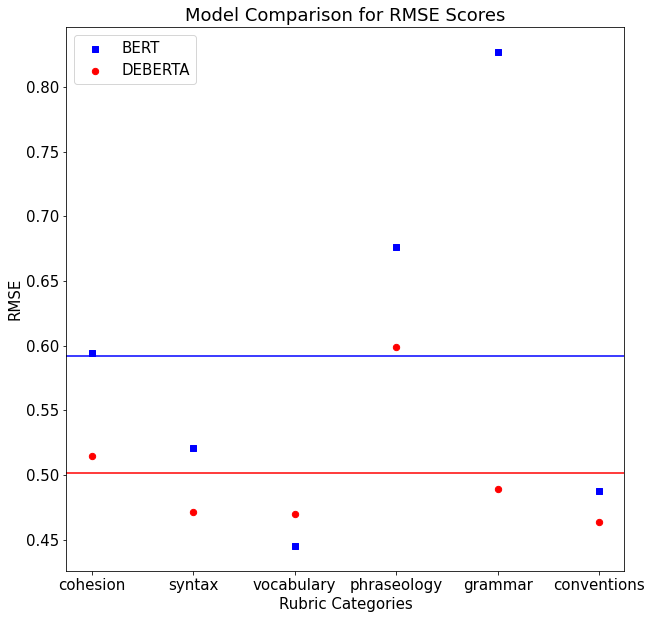

In [26]:
x = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

bert_rmse = [0.5944, 0.5209, 0.4450, 0.6766, 0.8272, 0.4873]
deberta_rmse = [0.5143, 0.4717, 0.4696, 0.5989, 0.4895, 0.4633]

plt.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

ax1.scatter(x, bert_rmse, s=40, c='b', marker="s", label='BERT')
ax1.scatter(x, deberta_rmse, s=40, c='r', marker="o", label='DEBERTA')
plt.legend(loc='upper left')
plt.ylabel("RMSE")
plt.xlabel("Rubric Categories")
plt.axhline(y = 0.5919, color = 'b', linestyle = '-')
plt.axhline(y = 0.5012, color = 'r', linestyle = '-')
plt.title('Model Comparison for RMSE Scores')
plt.show()